# Model fitting

In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

import plotly.graph_objects as go

import optuna
from optuna.samplers import TPESampler

from sklearn.linear_model import LinearRegression

from polymodel.utils import (
    find_soln_given_beta_and_no_control,
    logit10_vectorised,
    inverse_logit10,
)

from polymodel.params import PARAMS

from plots.fns import standard_layout

# I0

Default value of I0 is going to be found from the time series data and just kept as fixed.

Filter out those which are 0

Growth stage mapping used: 
- 2130 dd : GS61-65 (based on 2066 = GS61)
- 2387 dd : GS71
- 2515 dd : GS75

NB GS87 = 2900

Rounding to nearest 5.

## Growth stage mapping to degree days

In [3]:
gs_dd_map = (
    pd.DataFrame(dict(
        dd = [2066, np.nan, np.nan, np.nan, 2900],
        GS = [61, 63, 71, 75, 87]
    ))
    .set_index('GS')
    .interpolate(method='index')
    .reset_index()
)

gs_dd_map

,GS,dd
0,61,2066.000000
1,63,2130.153846
2,71,2386.769231
3,75,2515.076923
4,87,2900.000000


<AxesSubplot:xlabel='GS'>

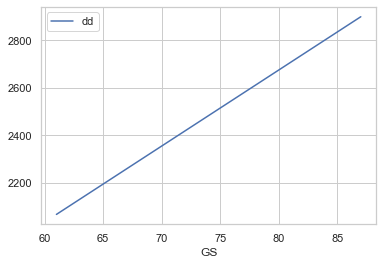

In [4]:
gs_dd_map.set_index('GS').plot()

Round to nearest integer:

In [5]:
gs_dd_map = gs_dd_map.assign(to_use = lambda df: round(df.dd))
gs_dd_map

,GS,dd,to_use
0,61,2066.000000,2066.0
1,63,2130.153846,2130.0
2,71,2386.769231,2387.0
3,75,2515.076923,2515.0
4,87,2900.000000,2900.0


In [6]:
gs_dd_map.to_use[0]

2066.0

No longer filter by cultivar, because all cultivars should have same I0

In [7]:
(
    pd.read_csv('../data/02_processed/I0_in_better_colnames.csv')
    
    .rename(columns = {
        'L2': 'I1',
        '17_06_gs71_l2': 'I2',
        '25_06_19_gs75_l2': 'I3',
    })
    
    .loc[lambda df: (
        (df.treatment=='a') & # untreated
        (df.I1>0) & 
        (df.I2>0) & 
        (df.I3>0))
    ]
    
    .reset_index(drop=True)
)

,no,par. No,rep,rk,plot,cultivar,treatment,16.05 vs 32-33,Unnamed: 8,27.05 vs 53 L4,...,Gulrust l1,Meldug l2,I2,Stb l1,I3,Stb l1.1,Yellow rust l1,02.07 vs81 gla,TGW(g),yield
0,1,1,1,1,101,1,a,2.0,0,15.0,...,0.1,0.0,12.0,1.0,20.0,7.0,5,30.0,36.34,84.195539
1,2,2,1,2,109,2,a,0.5,0,0.1,...,2.0,0.1,3.0,0.0,3.0,1.0,3,80.0,41.39,85.448056
2,3,3,1,3,117,3,a,5.0,0,20.0,...,10.0,0.0,30.0,10.0,50.0,20.0,30,0.0,30.15,51.400630
3,4,4,1,4,125,4,a,0.5,0,10.0,...,0.0,5.0,10.0,1.0,12.0,7.0,0,30.0,31.79,81.225216
4,5,5,1,5,133,5,a,6.0,0,30.0,...,0.0,0.0,40.0,7.0,80.0,20.0,0,1.0,35.97,68.919706
5,6,6,1,6,141,6,a,2.0,0,5.0,...,0.0,0.0,5.0,2.0,15.0,7.0,0,70.0,36.26,89.837828
6,13,13,2,13,233,4,a,0.0,0,15.0,...,0.0,1.0,10.0,1.0,15.0,5.0,0,70.0,38.19,90.607303
7,25,25,3,24,358,4,a,0.0,0,10.0,...,0.0,2.0,10.0,1.0,40.0,7.0,0,50.0,35.88,87.576302
8,38,38,2,11,218,3,a,0.0,0,10.0,...,1.0,0.0,20.0,5.0,80.0,20.0,10,2.0,34.86,73.897713
9,58,58,2,10,211,5,a,0.0,0,50.0,...,0.0,0.0,30.0,5.0,60.0,12.0,0,5.0,37.28,78.953886


In [8]:
I_at_diff_times = (
    pd.read_csv('../data/02_processed/I0_in_better_colnames.csv')
    
    .loc[:, [
             'treatment',
             # 'cultivar',
             'L2',
             '17_06_gs71_l2',
             '25_06_19_gs75_l2',
            ]
    ]
    
    .rename(columns = {
        'L2': 'I1',
        '17_06_gs71_l2': 'I2',
        '25_06_19_gs75_l2': 'I3',
    })
    
    .loc[lambda df: (
        (df.treatment=='a') & # untreated
        (df.I1>0) & 
        (df.I2>0) & 
        (df.I3>0))
    ]
    
    .drop('treatment', axis=1)
    
    .reset_index(drop=True)
    
    .assign(
        t0 = gs_dd_map.to_use[0],
        t1 = gs_dd_map.to_use[1],
        t2 = gs_dd_map.to_use[2],
        t3 = gs_dd_map.to_use[3],
        
        IL1 = lambda df: logit10_vectorised(0.01*df.I1),
        IL2 = lambda df: logit10_vectorised(0.01*df.I2),
        IL3 = lambda df: logit10_vectorised(0.01*df.I3),
    )
)

I_at_diff_times

,I1,I2,I3,t0,t1,t2,t3,IL1,IL2,IL3
0,5.0,12.0,20.0,2066.0,2130.0,2387.0,2515.0,-1.278754,-0.865301,-0.602060
1,0.1,3.0,3.0,2066.0,2130.0,2387.0,2515.0,-2.999565,-1.509650,-1.509650
2,10.0,30.0,50.0,2066.0,2130.0,2387.0,2515.0,-0.954243,-0.367977,0.000000
3,5.0,10.0,12.0,2066.0,2130.0,2387.0,2515.0,-1.278754,-0.954243,-0.865301
4,20.0,40.0,80.0,2066.0,2130.0,2387.0,2515.0,-0.602060,-0.176091,0.602060
5,0.2,5.0,15.0,2066.0,2130.0,2387.0,2515.0,-2.698101,-1.278754,-0.753328
6,1.0,10.0,15.0,2066.0,2130.0,2387.0,2515.0,-1.995635,-0.954243,-0.753328
7,2.0,10.0,40.0,2066.0,2130.0,2387.0,2515.0,-1.690196,-0.954243,-0.176091
8,10.0,20.0,80.0,2066.0,2130.0,2387.0,2515.0,-0.954243,-0.602060,0.602060
9,10.0,30.0,60.0,2066.0,2130.0,2387.0,2515.0,-0.954243,-0.367977,0.176091


In [9]:
stacked = (
    I_at_diff_times
    .filter(like='IL')
    .stack()
    .reset_index(level=1)
    .replace('IL1', gs_dd_map.to_use[1])
    .replace('IL2', gs_dd_map.to_use[2])
    .replace('IL3', gs_dd_map.to_use[3])
    .rename(columns={
        'level_1': 'time_dd', 
        0: 'stb'
    })
    .reset_index(drop=True)
)

stacked.head(5)

,time_dd,stb
0,2130.0,-1.278754
1,2387.0,-0.865301
2,2515.0,-0.602060
3,2130.0,-2.999565
4,2387.0,-1.509650


In [10]:
stacked.shape

(45, 2)

In [11]:
lr = LinearRegression().fit(
    np.array(stacked.time_dd).reshape(-1, 1),
    np.array(stacked.stb)
)

In [12]:
IL0_pred = lr.predict(np.array([1456]).reshape(-1, 1))[0]

In [13]:
IL0_pred

-3.818146392563964

In [14]:
I0_pred = inverse_logit10(IL0_pred)

In [15]:
tt = np.linspace(1456, stacked.time_dd.max(), 5)
model_preds = lr.predict(tt.reshape(-1,1))

## New (works with non-constant host)

In [16]:
class I0Objective:
    def __init__(self) -> None:
        self.df = stacked

    def __call__(self, trial):
        if trial is None:
            params = {'I0': 0.001, 'beta': 0.001}
        else:
            params = self.get_params(trial)
        
        res = self.run_model(params)
        
        score = np.sum(res.sq_residual)
        
        return score
    


    def run_model(self, params):
        t_vals = [PARAMS.T_1] + list(stacked.time_dd.unique())

        t_vals.sort()
        
        soln = find_soln_given_beta_and_no_control(
            params['beta'],
            params['I0'],
            t_vals
        )
        
        no_control_model = (
            pd.DataFrame(soln.T)
            .rename(columns={0: 'S', 1: 'I'})
            .assign(
                time_dd = t_vals,
                sev = lambda df: df.I / (df.S + df.I),
                sev_logit = lambda df: logit10_vectorised(df.sev)
            )
            .set_index('time_dd')
        )

        res = (
            no_control_model

            .join(
                stacked.set_index('time_dd'),
                how='outer'
            )

            .rename(columns = {
                'stb': 'data', 
                'sev_logit': 'model'
            })

            .loc[:, ['data', 'model']]

            .reset_index()

            .loc[lambda df: df.time_dd>1456]
            
            .assign(sq_residual = lambda df: (df.data - df.model)**2)
        )

        return res


    def get_params(self, trial):
        params = {
            "I0": trial.suggest_float(
                "I0",
                1e-6,
                1e-2
            ),
            "beta": trial.suggest_float(
                "beta",
                1e-5,
                1e-2,
                log=True
            ),
        }
        return params

In [17]:
optuna.logging.set_verbosity(
    optuna.logging.WARNING
)

In [18]:
sampler = TPESampler(seed=0)
study = optuna.create_study(sampler=sampler)
obj = I0Objective()

In [19]:
study.optimize(obj, n_trials=500)

In [20]:
study.best_trial

FrozenTrial(number=215, values=[16.07331495884618], datetime_start=datetime.datetime(2022, 4, 29, 15, 52, 30, 828616), datetime_complete=datetime.datetime(2022, 4, 29, 15, 52, 30, 855600), params={'I0': 0.009857031966008964, 'beta': 0.0086722866738886}, distributions={'I0': UniformDistribution(high=0.01, low=1e-06), 'beta': LogUniformDistribution(high=0.01, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=215, state=TrialState.COMPLETE, value=None)

In [21]:
study.best_params

{'I0': 0.009857031966008964, 'beta': 0.0086722866738886}

In [22]:
res = I0Objective().run_model(study.best_params)
res.head()

,time_dd,data,model,sq_residual
1,2130.0,-1.278754,-1.673355,0.155710
2,2130.0,-2.999565,-1.673355,1.758835
3,2130.0,-0.954243,-1.673355,0.517122
4,2130.0,-1.278754,-1.673355,0.155710
5,2130.0,-0.602060,-1.673355,1.147672


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='time_dd', ylabel='data'>

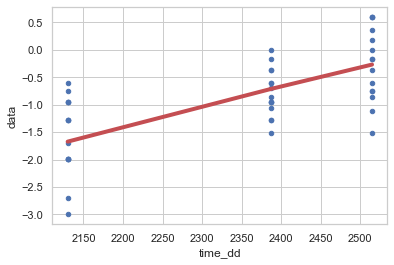

In [23]:
f, ax = plt.subplots()

res.set_index('time_dd').model.plot(ax=ax, lw=4, c='r')

res.plot.scatter(x='time_dd', y='data', ax=ax)

## Save I0 value?

In [24]:
I0_df = (
    pd.DataFrame(dict(I0_value = [study.best_params['I0']]))
)

I0_df

,I0_value
0,0.009857


In [25]:
if True:
    filename = '../data/03_model_inputs/I0_value.csv'
    print(f'saving to {filename}')
    I0_df.to_csv(filename)

saving to ../data/03_model_inputs/I0_value.csv


## Plot it

In [27]:
COLZ = sns.color_palette('muted').as_hex()

In [28]:
res.head()

,time_dd,data,model,sq_residual
1,2130.0,-1.278754,-1.673355,0.155710
2,2130.0,-2.999565,-1.673355,1.758835
3,2130.0,-0.954243,-1.673355,0.517122
4,2130.0,-1.278754,-1.673355,0.155710
5,2130.0,-0.602060,-1.673355,1.147672


In [91]:
I0 = I0_df.I0_value

In [108]:
tt = np.linspace(PARAMS.T_1, PARAMS.T_end, 500)

ss = find_soln_given_beta_and_no_control(
    study.best_params['beta'],
    study.best_params['I0'],
    tt
)

sev = ss[1, :] / (ss[0, :] + ss[1, :])

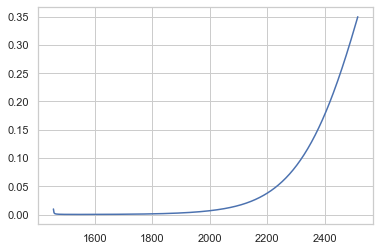

In [109]:
f, ax = plt.subplots()

ax.plot(tt[:], sev[:])

In [118]:
study.best_params['I0']

0.009857031966008964

In [117]:
sev[0]

0.009857031966008964

In [119]:
logit10_vectorised(0.01)

array(-1.99563519)

In [116]:
logit10_vectorised(sev[0])

array(-2.00195174)

In [140]:
from plotly.subplots import make_subplots
from plots.fns import get_text_annotation

In [145]:
def appendix_figure():
    
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        # horizontal_spacing=0.33,
    )
    
    data = [
        go.Scatter(
            x=tt,
            y=logit10_vectorised(sev),
            mode='lines',
            line=dict(color=COLZ[1]),
            showlegend=False,
        ),
        go.Scatter(
            x=res.time_dd,
            y=res.data,
            mode='markers',
            marker=dict(color=COLZ[0]),
            opacity=0.6,
            showlegend=False,
        ),
    ]
    
    data2 = [
        go.Scatter(
            x=tt,
            y=logit10_vectorised(ss[1,:]),
            mode='lines',
            line=dict(color=COLZ[1]),
            showlegend=False,
        ),
    ]
        
    
    fig.add_traces(data, rows=1, cols=1)
    
    fig.add_traces(data2, rows=2, cols=1)
    
    fig.update_layout(standard_layout(True, height=750))
    
    annotz = [
        get_text_annotation(-0.01, 1.05, 'A', size=20),
        get_text_annotation(-0.01, 0.5, 'B', size=20),
    ]
    
    fig.update_layout(annotations=annotz)
    
    ticktext = 100*np.concatenate([np.logspace(-4, -1, 4), [0.5, 0.8]])
    tickvals = logit10_vectorised(0.01*ticktext)
    
    fig.update_xaxes(title='Time (degree-days)', range=[1400, 2600], row=2)
    
    fig.update_yaxes(
        title='Severity, logit scale (%)',
        tickvals=tickvals,
        ticktext=ticktext,
        row=1,
    )
    
    fig.update_yaxes(
        title='Infectious tissue, logit scale (%)',
        tickvals=tickvals,
        ticktext=ticktext,
        range=[-4, 0],
        row=2,
    )
    
    return fig

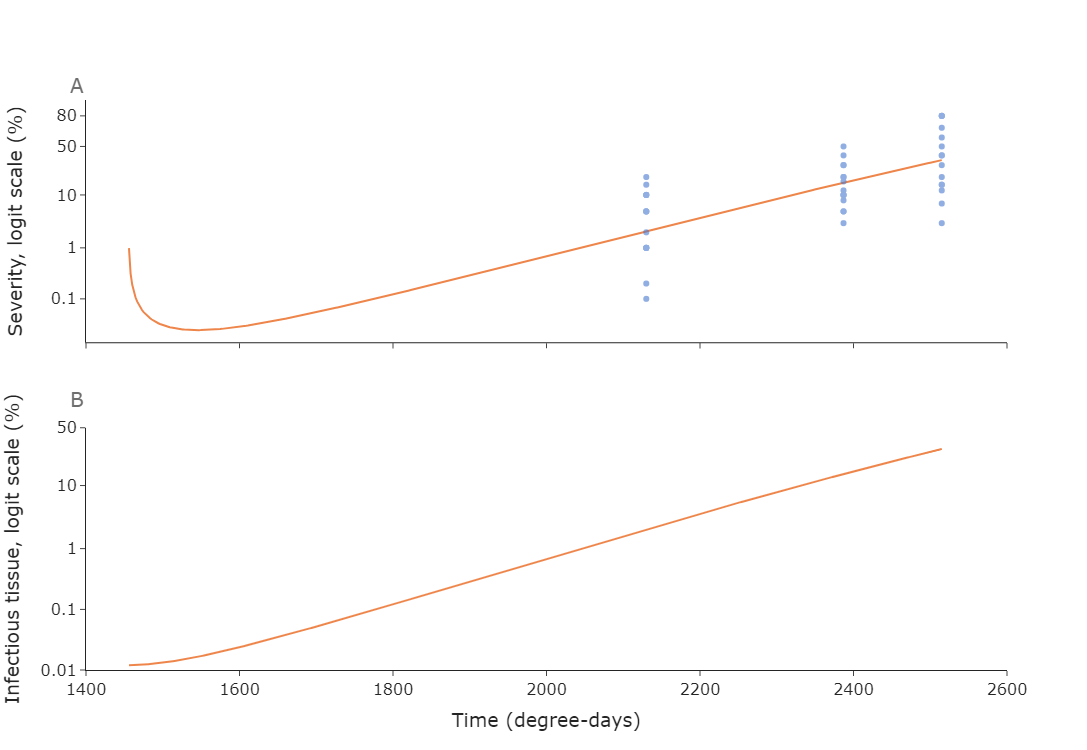

In [146]:
f = appendix_figure()
f.show()

In [147]:
f.write_image('../figures/paper_figs/app1_I0_plot.png')